In [1]:
import sys
# Installation  des dépendances
!{sys.executable} -m pip install -q -r "../requirements.txt"

import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Configuration du style des graphiques
sns.set_theme(style="whitegrid", context="talk")

In [2]:
def fetch_openfoodfacts_data(category, page_size=100):
    """
    Récupère les données nutritionnelles d'une catégorie donnée sur OpenFoodFacts.
    Args:
        category (str): La catégorie de produits (ex: 'biscuits')
        page_size (int): Nombre de produits à récupérer
    """
    url = "https://world.openfoodfacts.org/cgi/search.pl"
    params = {
        "action": "process",
        "tagtype_0": "categories",
        "tag_contains_0": "contains",
        "tag_0": category,
        "page_size": page_size,
        "json": 1,
        "fields": "product_name,brands,nutriscore_grade,nutriments,nova_group" 
    }
    
    print(f"📡 Interrogation de l'API pour : {category}...")
    try:
        response = requests.get(url, params=params, timeout=200)
        response.raise_for_status() # Vérifie les erreurs HTTP
        return response.json().get('products', [])
    except requests.exceptions.RequestException as e:
        print(f"❌ Erreur de connexion : {e}")
        return []

# Test de récupération
data_biscuits = fetch_openfoodfacts_data("biscuits", 200)
data_cereals = fetch_openfoodfacts_data("breakfast_cereals", 200)
raw_data = data_biscuits + data_cereals
print(f"✅ Succès : {len(raw_data)} produits bruts récupérés.")

📡 Interrogation de l'API pour : biscuits...
📡 Interrogation de l'API pour : breakfast_cereals...
❌ Erreur de connexion : 504 Server Error: Gateway Time-out for url: https://world.openfoodfacts.org/cgi/search.pl?action=process&tagtype_0=categories&tag_contains_0=contains&tag_0=breakfast_cereals&page_size=200&json=1&fields=product_name%2Cbrands%2Cnutriscore_grade%2Cnutriments%2Cnova_group
✅ Succès : 100 produits bruts récupérés.


In [3]:
data_biscuits

[{'brands': 'LU',
  'nova_group': 4,
  'nutriments': {'alcohol': 0,
   'alcohol_100g': 0,
   'alcohol_serving': 0,
   'alcohol_unit': '% vol',
   'alcohol_value': 0,
   'carbohydrates': 14,
   'carbohydrates_100g': 70,
   'carbohydrates_prepared_unit': 'g',
   'carbohydrates_serving': 14,
   'carbohydrates_unit': 'g',
   'carbohydrates_value': 14,
   'carbon-footprint-from-known-ingredients_100g': 15,
   'carbon-footprint-from-known-ingredients_product': 45,
   'carbon-footprint-from-known-ingredients_serving': 3,
   'energy': 392,
   'energy-kcal': 93,
   'energy-kcal_100g': 465,
   'energy-kcal_prepared_unit': 'kcal',
   'energy-kcal_serving': 93,
   'energy-kcal_unit': 'kcal',
   'energy-kcal_value': 93,
   'energy-kcal_value_computed': 94.3,
   'energy-kj': 392,
   'energy-kj_100g': 1960,
   'energy-kj_prepared_unit': 'kJ',
   'energy-kj_serving': 392,
   'energy-kj_unit': 'kJ',
   'energy-kj_value': 392,
   'energy-kj_value_computed': 396,
   'energy_100g': 1960,
   'energy_prepar

In [4]:

if not raw_data:
    print("⚠️ ATTENTION : Aucune donnée récupérée de l'API !")
    # On crée un DataFrame vide MAIS avec les colonnes attendues pour ne pas faire planter la suite
    df = pd.DataFrame(columns=['Nom', 'Marque', 'Nutriscore', 'NOVA', 'Sucre', 'Gras', 'Sel', 'Calories'])
else:
    # Ton code de transformation habituel
    products_list = []
    for item in raw_data:
        nutriments = item.get('nutriments', {})
        products_list.append({
            'Nom': item.get('product_name', 'Inconnu'),
            'Marque': item.get('brands', 'Inconnu'),
            'Nutriscore': str(item.get('nutriscore_grade', 'nan')), # Convertir en str pour éviter les bugs
            'NOVA': item.get('nova_group', np.nan),
            'Sucre': nutriments.get('sugars_100g', np.nan),
            'Gras': nutriments.get('fat_100g', np.nan),
            'Sel': nutriments.get('salt_100g', np.nan),
            'Calories': nutriments.get('energy-kcal_100g', np.nan)
        })
    df = pd.DataFrame(products_list)

# Sécurité supplémentaire : On vérifie si la colonne existe avant de la modifier
if 'Nutriscore' in df.columns and not df.empty:
    df['Nutriscore'] = df['Nutriscore'].str.upper()
    print(f"✅ DataFrame créé avec succès : {len(df)} lignes.")
    display(df.head())
else:
    print("❌ Echec critique : Le DataFrame est vide ou mal formé.")

print("Aperçu des données propres :")
display(df.head())
print(f"Dimensions finales : {df.shape}")

✅ DataFrame créé avec succès : 100 lignes.


,Nom,Marque,Nutriscore,NOVA,Sucre,Gras,Sel,Calories
0,Prince Goût Chocolat,LU,E,4.0,31.5000,17.5000,0.500000,465.0
1,Tonik,عربي,E,2.0,40.0000,22.2000,0.217000,504.0
2,Sésame,Gerblé,C,4.0,17.0000,18.0000,0.380000,467.0
3,Henry’s,Henry's,E,4.0,24.2353,10.8235,0.882353,440.0
4,KING COOKIES,Excelo,E,NaN,32.0000,24.0000,0.270000,483.0


Aperçu des données propres :


,Nom,Marque,Nutriscore,NOVA,Sucre,Gras,Sel,Calories
0,Prince Goût Chocolat,LU,E,4.0,31.5000,17.5000,0.500000,465.0
1,Tonik,عربي,E,2.0,40.0000,22.2000,0.217000,504.0
2,Sésame,Gerblé,C,4.0,17.0000,18.0000,0.380000,467.0
3,Henry’s,Henry's,E,4.0,24.2353,10.8235,0.882353,440.0
4,KING COOKIES,Excelo,E,NaN,32.0000,24.0000,0.270000,483.0


Dimensions finales : (100, 8)


In [5]:
# On supprime les lignes où il manque des infos critiques
df = df.dropna(subset=['Sucre (g/100g)', 'Gras (g/100g)', 'Nutriscore'])

# On s'assure qu'on a bien que des Nutriscores valides (A, B, C, D, E)
# Parfois l'API renvoie des erreurs ou des valeurs bizarres
valid_scores = ['A', 'B', 'C', 'D', 'E']
df = df[df['Nutriscore'].isin(valid_scores)]

# Tri pour l'ordre alphabétique (Esthétique pour les graphes)
df = df.sort_values('Nutriscore')

print(f"✅ Données prêtes pour analyse : {len(df)} produits valides.")
display(df.head())

KeyError: ['Sucre (g/100g)', 'Gras (g/100g)']

/tmp/ipykernel_7259/581300863.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


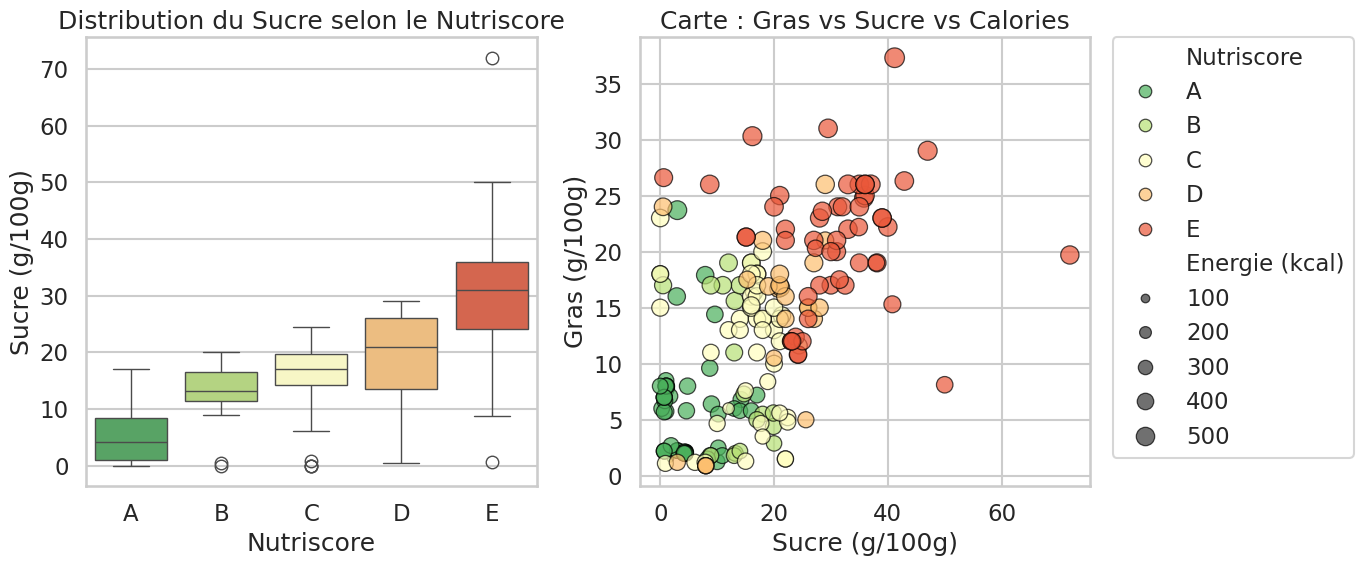

In [ ]:
# Visualisation et Analyse

plt.figure(figsize=(14, 6))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(
    data=df, 
    x='Nutriscore', 
    y='Sucre (g/100g)', 
    palette="RdYlGn_r"
)
plt.title("Distribution du Sucre selon le Nutriscore")

# Analyse multivariée : Relation Gras / Sucre / Calories
plt.subplot(1, 2, 2)
sns.scatterplot(
    data=df, 
    x="Sucre (g/100g)", 
    y="Gras (g/100g)", 
    hue="Nutriscore",     # La couleur dépend du score
    size="Energie (kcal)",# La taille du point dépend des calories
    sizes=(20, 200),      # Echelle de taille
    palette="RdYlGn_r",
    alpha=0.7,            # Transparence pour voir les points superposés
    edgecolor="black"
)
plt.title("Carte : Gras vs Sucre vs Calories")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout() # Ajuste automatiquement les marges
plt.show()